In [23]:
import os
import h5py
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
data_dir='ATL06/Byrd_glacier/'

# NOTE: We'll be working in matplotlib's widget mode, which lets us zoom in on our plots.  
# This means that the figures won't be rendered in the notebook until you run them.
# That means no spoilers (for now...)
%matplotlib widget


# Clouds over land ice: What problems they cause, and what to do about it.
This tutorial covers some of the reasons you might see weird results over ice when clouds start to blot out the surface signals.  The learning objectives I'd like to get to are:
- Understanding how clouds affect laser-altimetry signals
- Recognizing how these effects are manifest in the ATL06 product
- Gaining familiarity with the ATL06 parameters that can identify cloudy returns
This part of the tutorial will focus on clouds that cause gross errors in surface-height estimates.  

Along the way, we'll:

- develop a simple function for reading ICESat-2 data from hdf-5 files

If time allows, I'll also present on subtler effects caused by forward scattering of laser light by thin clouds, which can lead to smaller elevation biases.  The objectives of this part of the tutorial will be:
- Understanding how forward scattering of laser light by clouds can introduce biases in surface-height estimates
- Tools for identifying returns affected by forward scattering.

## 0.  Introduction: ATL06 review

<img src="images/ATL06_segment_model.tiff"  width=600 height=600>

Recall that ATL06 gives us surface heights based on the heights of collections of photons in a 40-m (horizontal) by w_surface_window (vertical) window.  It uses a variety of techniques to shrink the window to the smallest size that contains the surface without clipping off any signal photons.  In developing the algorithms, we decided that reporting some bad elevations was better than throwing away good elevations, and as a result, an ATL06 data file includes some bad returns, sometimes quite a few.  We're going to explore why, and how to tell the good from the bad.


### 1. An oversimplified desciption of snow and cloud radiative transfer

Clouds and snow reflect light in more or less the same way.  Light hits an ice grain and scatters into a random direction.  This happens over an over until the light is either absorbed or scattered out of the layer.  The number of expected scattering and absorption events per unit distance is called the _extinction coefficient_ ($\mu_e$}, and it depends on the size and density of the snow grains or ice grains doing the scattering.  For green light, absorption of light by ice isn't significant, and we're going to ignore it.  Because ice and snow scatter light mostly in the forward direction, it takes about 8 scattering events to turn a photon entirely around, so if we calculate (or read) a value for an extinction coefficient, we can scale it by $1/S$ and approximate the scattering process as isotropic (meaning that the photon can go in any direction with equal probability). A typical value for $S$ from the literature is 6-10, so we're going to use $S=10$. We're going to make a really simple model of light interacting with a cloud and an ice-sheet surface and see what the expected returns look like.

We can describe the beam of light going down from ICEsat-2 as a collection of $N_0$ photons.  When the light hits a cloud (or snow) layer whose top is at $z_0$, the photons are attenuated by the cloud such that:
$$dN(z)/dz = -\frac{\mu_s}{S} N(z)$$
and  the rate of photons scattered isotropically is:
$$N_S(z) = \frac{\mu_s}{S} N(z)$$
We're going to make the approximation that isotropically scattered photons don't interact with the layer again.  This is a good approximation for optically thin layers, and a bad one for thick layers, but we can get some intuition for pulse shapes even with this baggage.  

For a fine-grained, flat snow surface, all of the downgoing photons will be scattered over a short depth, $\delta$, so 
$$\int^{z_s}_{z_s-\delta} N_S=N_0$$
We know that in this situation, ICEsat-2 will detect about 3 photons/pulse (for a weak beam), or about 12 photons/pulse for a strong beam.  We can use this to approximate a return profile as:
$$N_d(z, z+\delta z) = N_e e^{-\tau(z)}\mu_s(z)\delta z$$
where $N_e$=12 for a strong beam $N_e$=3 for a weak beam, and $\tau(z)$ is the optical depth at $z$, defined:
$$\tau(z) = \int^\infty_z\mu_s(z) dz.$$

Because ICESat-2 operates both day and night, and because cloud surfaces and snow are both good reflectors, a lot of solar background photons come into the telescope along with the signal photons.  There are fiters that remove most of these photons, but a few of them make it through, at rates between ~0 and ~12 MHz.  In a vertical window $\delta_z$ wide, this gives $\frac{R_{BG}}{c/2} \delta_z$ photons.


This gives us everything we need to generate synthetic estimates of cloud returns.  Here's a quick Python function that generates the probability of a photon return in a series of height increments:  

In [24]:
import numpy as np
import matplotlib.pyplot as plt


def return_P(n0, z0, mu_s, BGR=0):
    """"
        Calculate the expected return rate for an ICESat-2 return 
        
        Inputs:
            z0: layer edges for cloud layers, in height, low to high (vector, n+1)
            mu_s: scattering coefficient (/m) for layers (vector, n)
            BGR: Background rate, in Hz
        outputs:
            z: layer center heights (meters, vector[n])
            P: probability of a photon returned from each layer (unitless, vector[n])
            tau: optical depth to the bottom of each layer
    """
    # reverse the inputs to be ITO depth
    depth=-z0[::-1]
    d_depth=np.diff(depth)
    mu_sr=mu_s[::-1]
    # optical depth at the layer boundaries
    tau=np.concatenate([[0], np.cumsum(d_depth*mu_sr)])
    # number of photons left in the beam at the layer boundaries
    N=n0*np.exp(-tau)
    # number of photons emitted in each layer
    P=-np.diff(N)
    z=(z0[0:-1]+z0[1:])/2
    # Background photon rate:
    N_BG=BGR/1.5e8*d_depth
    return z, P[::-1]+N_BG[::-1], tau[::-1]
     

### 1.1 Simulated returns from clouds and snow : signal strength

Let's see what the expected number of photons returned from a cloud top and a snow layer looks like:  A thick cloud could have $\mu_s$=0.005, and a loosely packed snow layer could have $\mu_s$=500.  We'll model the cloud and the snow surface as a step change in $\mu_s$ at z=0:

In [25]:
dz=0.2
z0=np.arange(-20, 10, dz)
zc, Pc, tau_c = return_P(12, z0, (z0[0:-1]<0).astype(np.float64)*0.01)
zs, Ps, tau_s = return_P(12, z0, (z0[0:-1]<0).astype(np.float64)*500)
plt.figure()
plt.subplot(121)
plt.plot(Pc/dz, zc, label='cloud')
plt.title('cloud')
plt.xlabel('return density, $m^{-1}$')
plt.ylabel('height, m')
plt.subplot(122)
plt.plot(Ps/dz, zs, label='snow')
plt.title('snow')
plt.xlabel('return density, $ph/m/pulse$')

FigureCanvasNbAgg()

Text(0.5, 0, 'return density, $ph/m/pulse$')

The peak return density from the cloud is around 0.12 photons/meter/pulse, while the return density from the snow is around 120 photons/meter/pulse (higher actually, but we're avearging in decimeter increments). This shows that under clear conditions, snow are extremely sharp, and cloud returns are much weaker.

### 1.2 Simluated returns from snow under clouds

If only one layer is present there's no ambiguity what might be a cloud and what might be a snow surface.  The problem is harder when there's a cloud on top of snow.  Let's define a function to calculate scattering coefficients for a cloud and a snow layer, and use it to plot return densities for different cloud thicknesses.  

In [26]:
def mu_profile(z0, z_cloud_top, z_surf=0, mu_cloud=0.005, mu_surf=500):
    zc=(z0[:-1]+z0[1:])/2
    mu_s=np.ones_like(zc)+np.NaN
    # make everything below zc=z_surf snow:
    mu_s[zc <= z_surf]=mu_surf
    #make everything between zc=0 and zc=z_cloud_top a cloud:
    mu_s[ zc >= z_surf ] = mu_cloud
    mu_s[ zc >= z_cloud_top ] =0
    return mu_s

# now make some plots
dz=0.2
# height domain is between -20 and 1100 m
z0=np.arange(-200, 2200, dz)

# we'll save these results for later.
P_save={}

fig=plt.figure()
for axes_ind, z_cloud_top in enumerate([20, 500, 1000, 1500]):
    mu_p=mu_profile(z0, z_cloud_top, mu_cloud=0.005, mu_surf=500)
    zc, P_profile, tau = return_P(12, z0, mu_p)
    N_surf=np.sum(P_profile[np.abs(zc)<10])
    fig.add_subplot(1, 4, axes_ind+1)
    plt.plot(P_profile, zc)
    plt.xlabel('ph/pulse/20cm')
    plt.title('$z_{top}$= %d m\n N_surf=%2.2f' % (z_cloud_top, N_surf))
    # save the results:
    P_save[z_cloud_top]=P_profile

FigureCanvasNbAgg()

Although the scaling on the plots obscures this, the peak amplitude of the cloud return is consistent at 0.012 photons/20 cm bin, while the surface return gets weaker as the cloud gets thicker.  At some point, the surface-finding algorithms no longer pick up the surface, but may pick up the cloud top instead.

### 1.3 Calculating the probability of a false detection

ATL06 is based on segments of data 40 m long, which usually contain data from 57 pulses.  It only identifies returns with at least 10 photons, and aggregates photons over vertical windows between 3 and 20 meters wide (with the width dependent on the segment slope).  Let's calculate the probability of ATL06 identifying the surface when we aggregate photons over 20 meters horizontally, 3 m vertically.

In [27]:
import scipy.stats as sps

def aggregate(z, P, N_horz, W):
    P_agg=np.zeros_like(P)
    for ii, zi in enumerate(z):
        els=np.abs(z-zi) <= W/2
        P_agg[ii]=N_horz*np.sum(P[els])
    return P_agg

fig=plt.figure(); plt.clf()
for ax_num, z_cloud_top in enumerate(P_save.keys()):
    P1=aggregate(zc, P_save[z_cloud_top], 57, 3)
    
    P_10ph = 1-sps.poisson.cdf(10, P1)
    P_surf=np.max(P_10ph[zc < 50])
    fig.add_subplot(1, 4, ax_num+1)
    plt.plot(P_10ph, zc)
    plt.title('$z_{top}$= %d m\n $P_{surf}=%1.3f$' % (z_cloud_top, P_surf))
    plt.xlabel('$P_{10 ph.}$')

FigureCanvasNbAgg()

We see here that there's a large vertical region just below the top of the cloud where it's very easy to find windows containing 10 photons or more.  In these cases, we're counting on the surface return to be stronger than the cloud return, but if the cloud is thick enough to obscure the surface, it's easy to find returns higher in the atmosphere.

In [28]:
# Exercise for participants: Explore: 
# what happens when the bacground rate is larger?  Try making these plots with BGR = 10 MHz.  What do you see?

#What happens when the vertical window size is larger?  Try making these plots with W=10 or W=20.  What do you see?


#### Observations that (I hope) some of you will have made:
1.  Once the background rate becomes large (5 MHz+) it's pretty common to see large regions where there might be a false surface detection
2. For large windows, the region where we might see false surface detections is much larger, and isn't just restricted to the cloud top and the surface

Based on these observations, we should be prepared to see a lot of false surface detections, and we should expect worse results in cases where the surface window has not converged to a small value.  However, if we see large numbers of photons, especially concentrated in a small window, we should be prepeared to believe that they are from the surface!


## 2. Relating cloud effects to ATL06 data parameters

Our problem comes when the ground return is not strong enough to trigger the signal finder, and we start to see triggers associated with:
- Cloud tops
- Random clusterings of background photons

These should both be statistically distinct from surface returns because:
- The returns are less intense than a high-quality surface return
- The photons are more widely vertcally spread than those in surface returns
- The surface window cannot converge on a small vertical window around the surface
- Surface heights and slopes are not consistent between adjacent segments

There are a few ATL06 parameters that help quantify these distinctions. 
In the /gtxx/land_ice_segments group:
- h_li_sigma : the estimated error in the surface-height estimate
In the /gtxx/land_ice_segments/fit_statistics groups:
- n_fit_photons : The number of photons found in each segment
- w_surface_window_final : The size of the converged surface window
- h_rms_misft : The RMS misfit of photons in the surface window
- h_robust_sprd : A percentile-based estimate of the spread of the photons, corrected for background
- snr : the observed signal-to-noise ratio for the selected photons
- snr_significance : The estimated probability that a random clustering of photons would produce the observed SNR
- dh_fit_dx : the along-track segment slope
And in /gtxx/land_ice_segments/geophysical:
- r_eff : the effective reflectance of the surface

There's one more parameter that puts a few of these ideas together, in /gtxx/land_ice_segments:
- atl06_quality_summary : a combination of parameters (h_li_sigma, n_fit_photons/w_surface_window_final, and signal_selection_source).  Zero indicates a good segment, 1 indicates a possibly bad segment.


### 2.1 Taking our picture of cloud effects to the ice sheet
We're next going to look at data from Byrd Glacier, in Antarctica.  This is one of the big outlet glaciers dumping ice from the East Antarctic plateau into the Ross Ice Shelf.  Here's a shaded-relief map from the REMA.
<img src="https://www.gislounge.com/wp-content/uploads/2018/09/mulock-glacier-dem.jpg">

The glacier flows west to east (the REMA image is south-end-up, so east is on the left).  The inland catchment of the glacier should have a smooth ice surface, but the glacier trunk and the area where it joins the ice shelf are heavily crevassed.

I've pulled the ICESat-2 data for the Byrd catchment, and it's stored on S3, so you can grab it with this command:

    aws s3 sync s3://pangeo-data-upload-oregon/icesat2/Clouds_and_filtering_tutorial/Byrd_glacier
        
Once that has finished downloading, take a look at what's there, using some basic python hdf5 code.  This takes about a minute to run.

In [30]:
data_dir='/home/jovyan/ATL06/Byrd_glacier/'
D6=[]
pairs=[1, 2, 3]
beams=['l','r']
datasets=['latitude','longitude','h_li','atl06_quality_summary', 'x_atc','y_atc']
files=glob(data_dir+'/*.h5')
for ii, file in enumerate(files):
    this_name=os.path.basename(file)
    with h5py.File(file) as h5f:
        for pair in pairs:
            for beam in beams:
                temp={}
                for dataset in datasets:
                    DS='/gt%d%s/land_ice_segments/%s' % (pair, beam, dataset)
                    try:
                        temp[dataset]=np.array(h5f[DS])
                    except KeyError:
                        pass
                if len(temp) > 0:
                    D6.append(temp)
print("read %d beam/pair combinations" % (len(D6)))

# now plot the results:
plt.figure();
for Di in D6:
    plt.scatter(Di['longitude'], Di['latitude'], c=Di['h_li'], vmin=0, vmax=2000, linewidth=0)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

read 250 beam/pair combinations


FigureCanvasNbAgg()

This plot is opposite the orientation of the REMA map, but we can see the trunk of the glacier (dark blue, right-center) and we can see the plateau (bright yellow, at left).

It looks like some of those tracks worked really well, and some of them didn't.  It's not all that much fun typing in all that code every time we want to read an ATL06 file.  Let's make a function to do it:

In [31]:
def ATL06_to_dict(filename, dataset_dict):
    """
        Read selected datasets from an ATL06 file
        
        Input arguments:
            filename: ATl06 file to read
            dataset_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
        Output argument:
            D6: a list of dictionaries containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in each element of D6.
    """
    D6=[]
    pairs=[1, 2, 3]
    beams=['l','r']

    with h5py.File(file) as h5f:
        for pair in pairs:
            for beam_ind, beam in enumerate(beams):
                temp={}
                for group in dataset_dict.keys():
                    for dataset in dataset_dict[group]:
                        DS='/gt%d%s/%s/%s' % (pair, beam, group, dataset)
                        try:
                            temp[dataset]=np.array(h5f[DS])
                        except KeyError:
                            pass
                if len(temp) > 0:
                    temp['pair']=np.zeros_like(temp['h_li'])+pair
                    temp['beam']=np.zeros_like(temp['h_li'])+beam_ind
                    temp['filename']=filename
                    D6.append(temp)
    return D6

Now we can loop over the files and start to get an idea of which ones are the good ones and which ones are the bad ones. Let's look at the first five files, plotting the surface height as a function of x_atc for the first beam/pair combination (gt1l):

In [32]:
# first define a dataset dictionary.  This tells our script what fields to read and where to find them
dataset_dict={'land_ice_segments': ['h_li','latitude','longitude'],
             'land_ice_segments/ground_track':['x_atc']}

for file in files[0:3]:
    this_D6=ATL06_to_dict(file, dataset_dict)
    plt.figure()
    plt.plot(this_D6[0]['x_atc'], this_D6[0]['h_li'],'.')
    plt.title(os.path.basename(this_D6[0]['filename']))


FigureCanvasNbAgg()

FigureCanvasNbAgg()

FigureCanvasNbAgg()

That doesn't look good either- lots of those elevations are on the order of $10^{38}$ m, which is a bit high for Antarctica.  Our function is doing something dumb: In fact, it's not handling no-data values correctly.  We need to read the '\_FillValue' attribute for field, and set the elements with that value to NaN.  Here's a fixed version of the function:

In [33]:
def ATL06_to_dict(filename, dataset_dict):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            dataset_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a list of numpy arrays containing the 
                data
    """
    D6=[]
    pairs=[1, 2, 3]
    beams=['l','r']

    with h5py.File(filename) as h5f:
        for pair in pairs:
            for beam_ind, beam in enumerate(beams):
                # check if a beam exists, if not, skip it
                if '/gt%d%s/land_ice_segments' % (pair, beam) not in h5f:
                    continue
                temp={}
                for group in dataset_dict.keys():
                    for dataset in dataset_dict[group]:
                        DS='/gt%d%s/%s/%s' % (pair, beam, group, dataset)
                        # some parameters have a _FillValue attribute.  If it exists, use it to identify bad values, and set them to np.NaN
                        try:
                            temp[dataset]=np.array(h5f[DS])
                            if '_FillValue' in h5f[DS].attrs:
                                fill_value=h5f[DS].attrs['_FillValue']
                                temp[dataset][temp[dataset]==fill_value]=np.NaN
                        except KeyError as e:
                            pass
                if len(temp) > 0:
                    temp['pair']=np.zeros_like(temp['h_li'])+pair
                    temp['beam']=np.zeros_like(temp['h_li'])+beam_ind
                    temp['filename']=filename
                    D6.append(temp)
    return D6

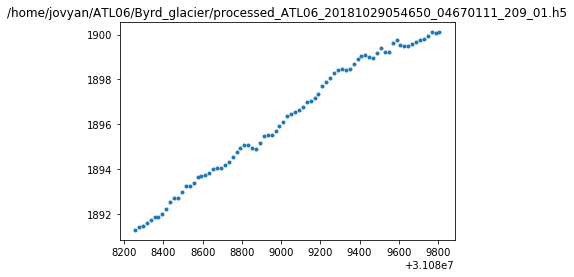

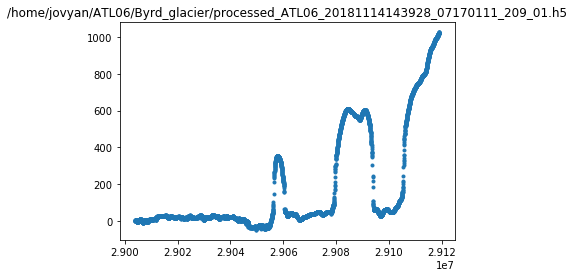

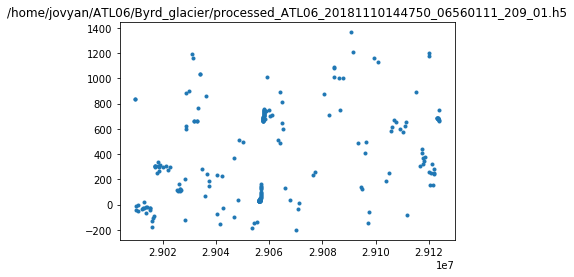

In [11]:
for file in files[0:3]:
    this_D6=ATL06_to_dict(file, dataset_dict)
    plt.figure()
    plt.plot(this_D6[0]['x_atc'], this_D6[0]['h_li'],'.')
    plt.title(this_D6[0]['filename'])

That's better!  At least, it's better in that there are not elevations that are wildy unphysical.  The data quality is pretty variable, though.  Take a minute to look through some of the files -- partner up with some of the people around you to find some interesting examples, and we'll get back together in a few minutes.  You can refer to the files you've found by beam number and the count within the list of files

In [12]:
# Workspace

In [39]:
# here are some of the files that I picked out as interesting:

rough_files=['/home/jovyan/ATL06/Byrd_glacier/processed_ATL06_20181102150421_05340111_209_01.h5', 
     '/home/jovyan/ATL06/Byrd_glacier/processed_ATL06_20181021060328_03450111_209_01.h5',
     '/home/jovyan/ATL06/Byrd_glacier/processed_ATL06_20181112153048_06870111_209_01.h5']

In [40]:
D6=ATL06_to_dict(rough_files[0], dataset_dict)
markers=['.','+']
plt.figure()
for ind, seg in enumerate(D6[0:2]):     
    plt.plot(seg['x_atc'], seg['h_li'],marker=markers[ind], color='k', linestyle='')
    plt.title(seg['filename'])
    

FigureCanvasNbAgg()

This one looks messy!  Segments are scattered between -2km and +2.5 km, and aren't at all consistent with each other.  This one likely has thick clouds that have obscured the surface entirely, and the signal finder has found some random clusters of points with high signal-to-noise ratios.

In [41]:
D6=ATL06_to_dict(rough_files[1], dataset_dict)
markers=['.','+']
plt.figure()
for ind, seg in enumerate(D6[0:2]):     
    plt.plot(seg['x_atc'], seg['h_li'],marker=markers[ind], color='k', linestyle='')
    plt.title(seg['filename'])

FigureCanvasNbAgg()

This one looks somewhat better.  There are some good-signal areas mixed in with the bad.

In [42]:
D6=ATL06_to_dict(rough_files[2], dataset_dict)
markers=['.','+']
plt.figure()
for ind, seg in enumerate(D6[0:2]):     
    plt.plot(seg['x_atc'], seg['h_li'],marker=markers[ind], color='k', linestyle='')
    plt.title(seg['filename'])

FigureCanvasNbAgg()

### Exercise for participants:
Look at the Byrd Glacier profiles.  
- Use the matplotlib scatter function to plot the parameters as a function of x_atc and h_li, and see which parameters correspond to good returns, which correspond to clouds.
- See which returns are lost if we use the parameter as a threshold

In [43]:
# Example:  
dataset_dict['/land_ice_segments/fit_statistics']=['h_rms_misfit']
D6=ATL06_to_dict(rough_files[1], dataset_dict)
plt.figure()
plt.subplot(121)
plt.scatter(D6[0]['x_atc'], D6[0]['h_li'], c=D6[0]['h_rms_misfit'], linewidth=0); plt.colorbar()
plt.subplot(122)
good=np.where(D6[0]['h_rms_misfit'] < .5)[0]
plt.plot(D6[0]['x_atc'][good], D6[0]['h_li'][good],'.')

FigureCanvasNbAgg()

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


Once you have picked out a set of filtering parameters you like, compare the results with the atl06_quality_summary. Do you have anything you like better?  Regenerate the plot from the top of this section where we mapped the heights for Byrd Glacier using plt.scatter()

There is one more way of flagging bad data that we can try, that can help clean up the remaining bad segments.  Recall that the the ATL06 data model fits both the height and the surface slope of segments: 

<img src="images/dh_segment.tiff"  width=500 height=450>

Let's look at the segments including their slopes:

In [19]:
def seg_slope_plot(D6):
    """
    Plot a sloping line for each ATL06 segment
    """
    #define the heights of the segment endpoints.  Leave a row of NaNs so that the endpoints don't get joined
    h_ep=np.zeros([3, D6['h_li'].size])+np.NaN
    h_ep[0, :]=D6['h_li']-D6['dh_fit_dx']*20
    h_ep[1, :]=D6['h_li']+D6['dh_fit_dx']*20
    # define the x coordinates of the segment endpoints
    x_ep=np.zeros([3,D6['h_li'].size])+np.NaN
    x_ep[0, :]=D6['x_atc']-20
    x_ep[1, :]=D6['x_atc']+20

    plt.plot(x_ep.T.ravel(), h_ep.T.ravel())

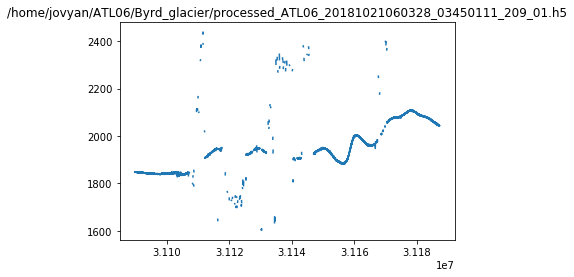

In [20]:
# to try this, we'll need to add dh_fit_dx to the data dictionary:
dataset_dict['land_ice_segments/fit_statistics']=['dh_fit_dx']

D6=ATL06_to_dict(rough_files[1], dataset_dict)
markers=['.','+']
plt.figure()
for ind, seg in enumerate(D6[0:1]):     
    seg_slope_plot(seg)
    plt.title(seg['filename'])

When we zoom in we can see that the "smooth" section is a little messy (maybe crevassed), but that the slopes in the cloudy section are really big.  We can use this to define a new filtering strategy that can delete some of the worst segments:

In [21]:
def seg_difference_filter(D6, tol=2):
    """
    seg_difference_filter: Use elevations and slopes to find bad ATL06 segments
    
    
    Inputs: 
        D6: a granule of ATL06 data, in dictionary format.  Must have entries:
            x_atc, h_li, dh_fit_dx
        tol: a tolerance.  Segments whose ends are different from their neighbors 
             by more than tol are marked as bad
    Returns:
        good: an array the same size as D6['h_li'].  True  entries indicate that 
            both ends of the segment are compatible with the segment's neighbors
        delta_h_seg: an array the same size as D6['h_li'].  Gives the largest 
            endpoint difference for each segment    
    """
    h_ep=np.zeros([2, D6['h_li'].size])+np.NaN
    h_ep[0, :]=D6['h_li']-D6['dh_fit_dx']*20
    h_ep[1, :]=D6['h_li']+D6['dh_fit_dx']*20
    delta_h_seg=np.zeros_like(D6['h_li'])
    delta_h_seg[1:]=np.abs(D6['h_li'][1:]-h_ep[1, :-1])
    delta_h_seg[:-1]=np.maximum(delta_h_seg[:-1], D6['h_li'][:-1]-h_ep[0, 1:])
    good=delta_h_seg < tol
    return good, delta_h_seg


## Exercise for participants: Try out the seg_difference_filter.  Generate a finalized map of elevations for Byrd Glacier

In [ ]:
##Workspace

# Summary of this part of the tutorial:  
- Clouds tend to produce weaker-than-normal returns
- We can identify low-quality surface returns with a variety of parameters.  